In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

!pip install transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00


In [ ]:
kindle = pd.read_csv('/content/all_kindle_review .csv')
df = kindle.drop(columns = ['Unnamed: 0','Unnamed: 0.1','helpful','reviewTime','reviewerID','reviewerName','summary','unixReviewTime'])
df.head()

,asin,rating,reviewText
0,B0033UV8HI,3,"Jace Rankin may be short, but he's nothing to ..."
1,B002HJV4DE,5,Great short read. I didn't want to put it dow...
2,B002ZG96I4,3,I'll start by saying this is the first of four...
3,B002QHWOEU,3,Aggie is Angela Lansbury who carries pocketboo...
4,B001A06VJ8,4,I did not expect this type of book to be in li...


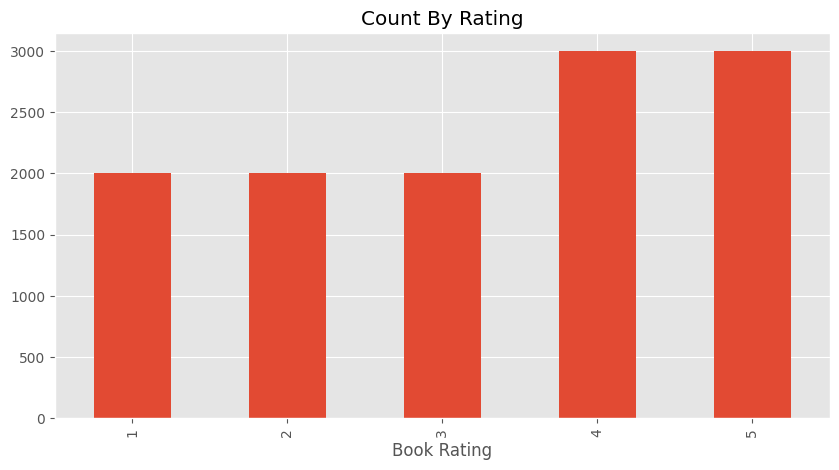

In [ ]:
grph = df['rating'].value_counts().sort_index().plot(kind='bar', title='Count By Rating', figsize=(10,5))
grph.set_xlabel('Book Rating')
plt.show()

###Vader Seniment Scoring

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviewText']
    myid = row['asin']
    if isinstance(text, str):
        res[myid] = sia.polarity_scores(text)
    else:
        print(f"Skipping row {i} with non-string value in 'Tweet_content' column")


  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(res).T

,neg,neu,pos,compound
B0033UV8HI,0.190,0.730,0.080,-0.9835
B002HJV4DE,0.000,0.405,0.595,0.9719
B002ZG96I4,0.024,0.809,0.167,0.9815
B002QHWOEU,0.078,0.571,0.351,0.6902
B001A06VJ8,0.000,1.000,0.000,0.0000
...,...,...,...,...
B002LLNFDA,0.000,0.773,0.227,0.9847
B0040JI3P6,0.077,0.901,0.022,-0.6008
B002KFD0VY,0.053,0.719,0.228,0.9983
B003VYBFZQ,0.000,0.786,0.214,0.9106


In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'asin'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders

,asin,neg,neu,pos,compound,rating,reviewText
0,B0033UV8HI,0.190,0.730,0.080,-0.9835,3,"Jace Rankin may be short, but he's nothing to ..."
1,B0033UV8HI,0.190,0.730,0.080,-0.9835,3,"The story is strong, moving and beautifully wr..."
2,B0033UV8HI,0.190,0.730,0.080,-0.9835,2,I hate to give a book a low rating based on te...
3,B002HJV4DE,0.000,0.405,0.595,0.9719,5,Great short read. I didn't want to put it dow...
4,B002HJV4DE,0.000,0.405,0.595,0.9719,4,If I ever find myself near hypothermic after m...
...,...,...,...,...,...,...,...
11995,B002LLNFDA,0.000,0.773,0.227,0.9847,4,I thought I had it all figured out in the firs...
11996,B0040JI3P6,0.077,0.901,0.022,-0.6008,2,"The plot for this book was well thought out, b..."
11997,B002KFD0VY,0.053,0.719,0.228,0.9983,4,Very good. Nicole Kimberling's writing is incr...
11998,B003VYBFZQ,0.000,0.786,0.214,0.9106,2,I think her main goal is to sell you her books...


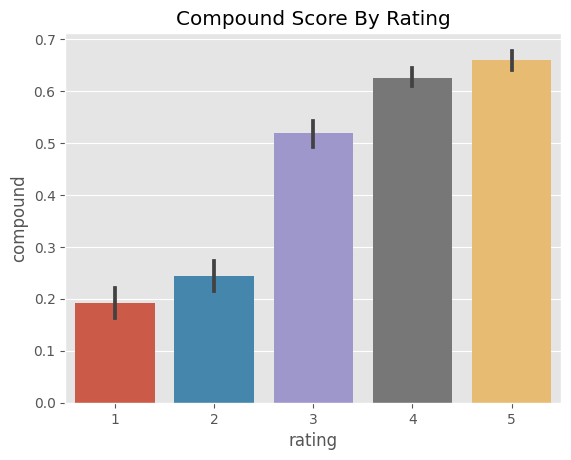

In [ ]:
ax = sns.barplot(data=vaders, x='rating', y='compound' )
ax.set_title('Compound Score By Rating')
plt.show()

### Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def polarity_scores_roberta(example, max_length=512):
  encoded_text = tokenizer(example, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores = np.array(scores)
  scores = scores.reshape(3)
  scores_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
import itertools

res = {}
for i, row in tqdm(itertools.islice(df.iterrows(), 200), total=200):
    text = row['reviewText']
    myid = row['asin']
    if isinstance(text, str):
        vader_results = sia.polarity_scores(text)
        vader_results_rename = {}
        for key, value in vader_results.items():
          vader_results_rename[f'vader_{key}'] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_results_rename, **roberta_result}
        res[myid] = both
    else:
        print(f"Skipping row {i} with non-string value in 'Tweet_content' column")

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = pd.merge(df, results_df, how='left', left_index=True, right_index=True)

In [ ]:
results_df.head()

,asin,rating,reviewText,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,B0033UV8HI,3,"Jace Rankin may be short, but he's nothing to ...",B0033UV8HI,0.136,0.723,0.142,0.4875,0.455733,0.375000,0.169267
1,B002HJV4DE,5,Great short read. I didn't want to put it dow...,B002HJV4DE,0.044,0.673,0.283,0.9645,0.003876,0.012527,0.983597
2,B002ZG96I4,3,I'll start by saying this is the first of four...,B002ZG96I4,0.000,0.862,0.138,0.8555,0.007205,0.095503,0.897291
3,B002QHWOEU,3,Aggie is Angela Lansbury who carries pocketboo...,B002QHWOEU,0.078,0.851,0.070,-0.1280,0.036467,0.272560,0.690974
4,B001A06VJ8,4,I did not expect this type of book to be in li...,B001A06VJ8,0.000,0.861,0.139,0.4404,0.018187,0.128028,0.853786


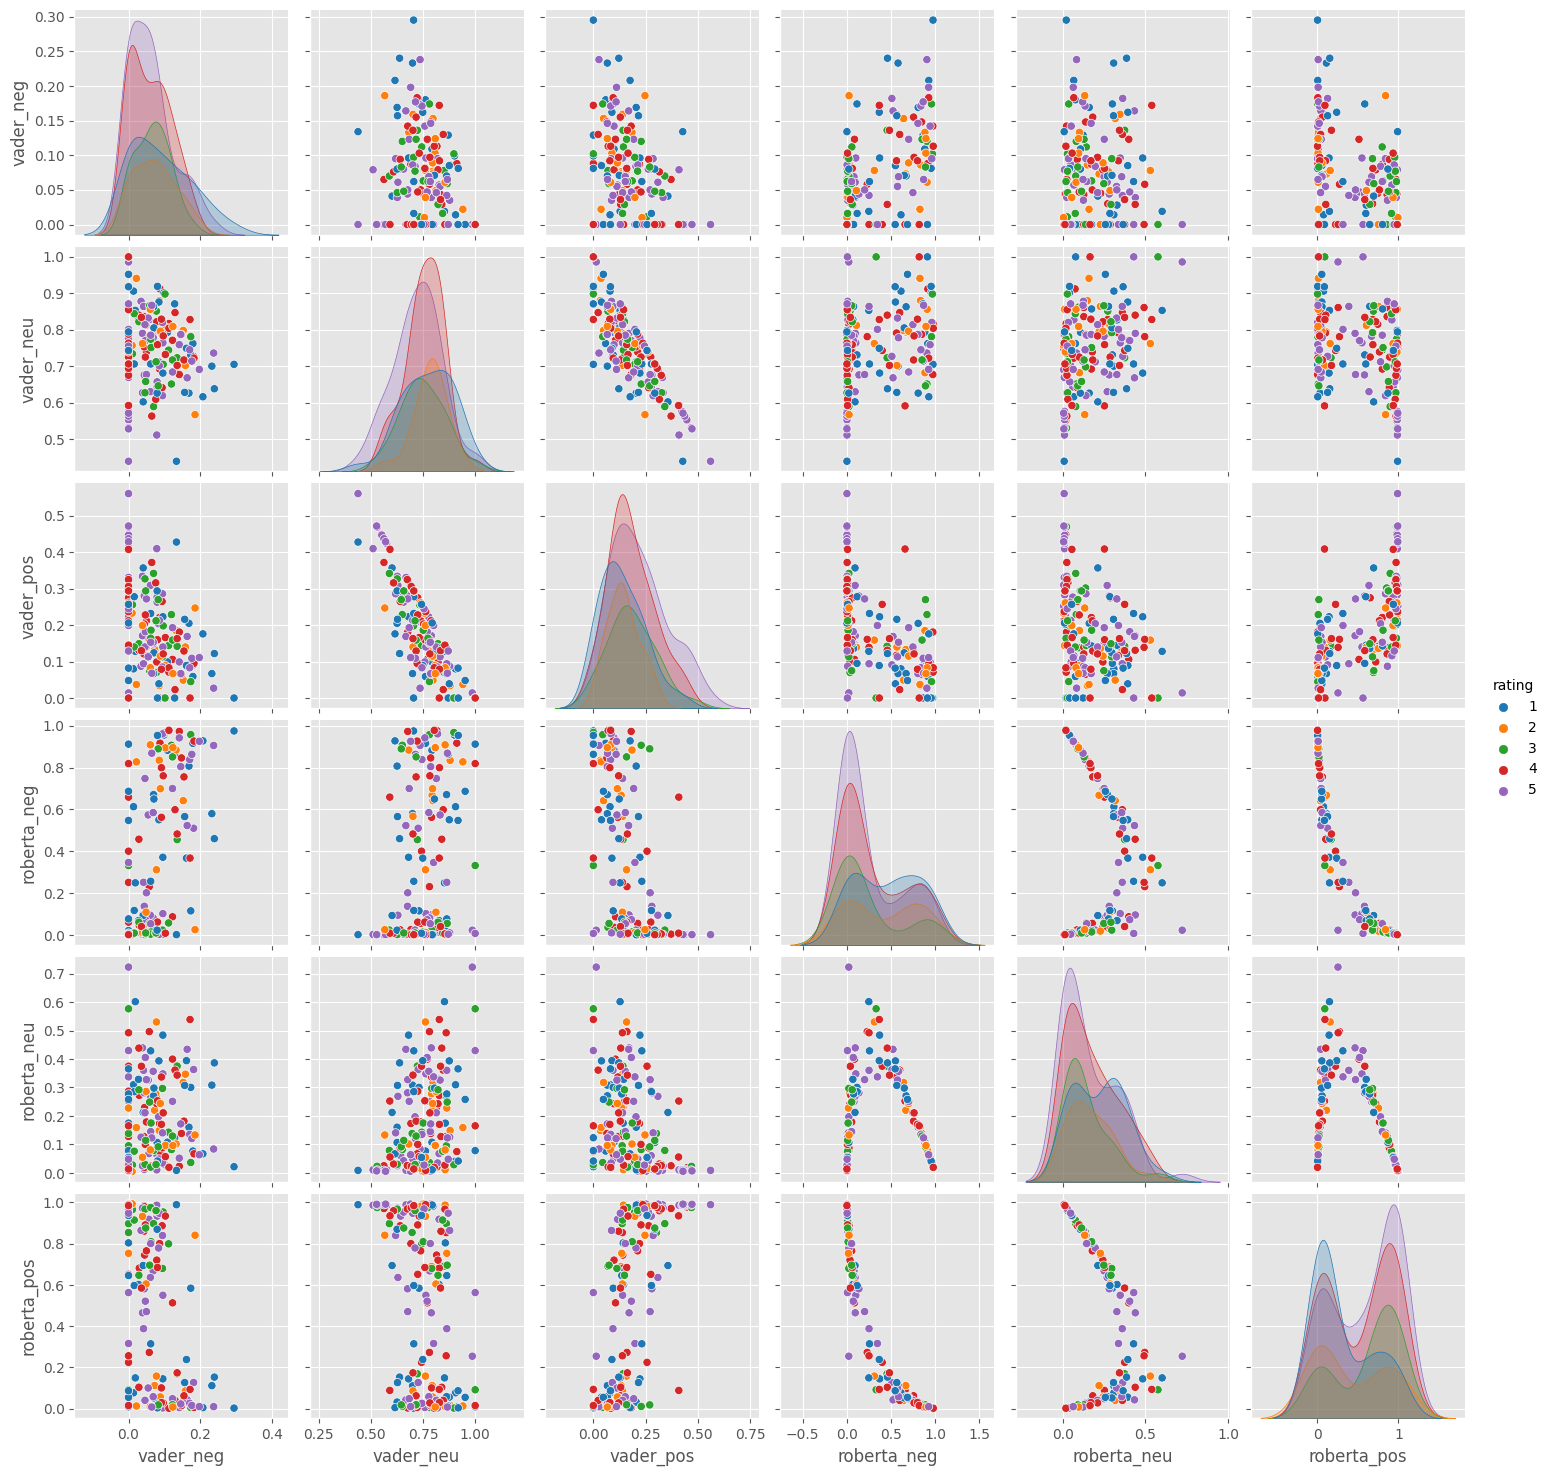

In [ ]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos','roberta_neg', 'roberta_neu', 'roberta_pos'], hue='rating', palette='tab10')
plt.show()